<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:09:05] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


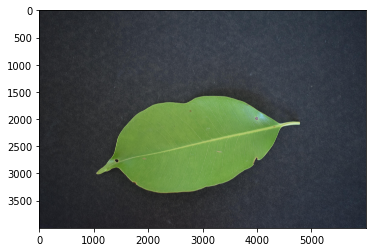

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

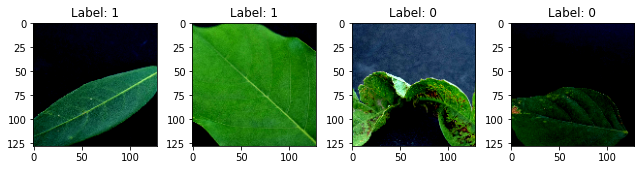

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:09:11] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:09:13] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.285128768980147 samples/sec                   batch loss = 1.8259339332580566 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2980820556489905 samples/sec                   batch loss = 0.759050726890564 | accuracy = 0.575


Epoch[1] Batch[15] Speed: 1.2960852733868844 samples/sec                   batch loss = 0.4502713680267334 | accuracy = 0.5833333333333334


Epoch[1] Batch[20] Speed: 1.3044960252532622 samples/sec                   batch loss = 0.772850513458252 | accuracy = 0.6125


Epoch[1] Batch[25] Speed: 1.300128624051225 samples/sec                   batch loss = 0.6905884146690369 | accuracy = 0.59


Epoch[1] Batch[30] Speed: 1.2955960417992498 samples/sec                   batch loss = 0.7168991565704346 | accuracy = 0.5833333333333334


Epoch[1] Batch[35] Speed: 1.3013608769121758 samples/sec                   batch loss = 0.8435078859329224 | accuracy = 0.5714285714285714


Epoch[1] Batch[40] Speed: 1.297251288497178 samples/sec                   batch loss = 0.7654829025268555 | accuracy = 0.575


Epoch[1] Batch[45] Speed: 1.3014724283315038 samples/sec                   batch loss = 0.448638379573822 | accuracy = 0.5944444444444444


Epoch[1] Batch[50] Speed: 1.2982626626183247 samples/sec                   batch loss = 0.7368317246437073 | accuracy = 0.6


Epoch[1] Batch[55] Speed: 1.2981903334387999 samples/sec                   batch loss = 0.4571409225463867 | accuracy = 0.6136363636363636


Epoch[1] Batch[60] Speed: 1.296947331258131 samples/sec                   batch loss = 0.5085193514823914 | accuracy = 0.6166666666666667


Epoch[1] Batch[65] Speed: 1.3028422827099515 samples/sec                   batch loss = 0.7433754205703735 | accuracy = 0.6153846153846154


Epoch[1] Batch[70] Speed: 1.303967789915361 samples/sec                   batch loss = 0.9106482863426208 | accuracy = 0.6178571428571429


Epoch[1] Batch[75] Speed: 1.2987501906259264 samples/sec                   batch loss = 0.6638821363449097 | accuracy = 0.6266666666666667


Epoch[1] Batch[80] Speed: 1.29653810159343 samples/sec                   batch loss = 1.5346680879592896 | accuracy = 0.634375


Epoch[1] Batch[85] Speed: 1.2960203949284903 samples/sec                   batch loss = 0.3884626030921936 | accuracy = 0.6352941176470588


Epoch[1] Batch[90] Speed: 1.2934625818127485 samples/sec                   batch loss = 0.7384530901908875 | accuracy = 0.65


Epoch[1] Batch[95] Speed: 1.3007178859315258 samples/sec                   batch loss = 0.6028380393981934 | accuracy = 0.6473684210526316


Epoch[1] Batch[100] Speed: 1.307595663611259 samples/sec                   batch loss = 1.0683410167694092 | accuracy = 0.6375


Epoch[1] Batch[105] Speed: 1.3084971903978118 samples/sec                   batch loss = 0.4441928565502167 | accuracy = 0.6309523809523809


Epoch[1] Batch[110] Speed: 1.2992007582768097 samples/sec                   batch loss = 0.25179702043533325 | accuracy = 0.6295454545454545


Epoch[1] Batch[115] Speed: 1.3024975770146026 samples/sec                   batch loss = 0.689852774143219 | accuracy = 0.6304347826086957


Epoch[1] Batch[120] Speed: 1.3082041598750402 samples/sec                   batch loss = 0.793345034122467 | accuracy = 0.6333333333333333


Epoch[1] Batch[125] Speed: 1.3011873792731283 samples/sec                   batch loss = 0.47147518396377563 | accuracy = 0.644


Epoch[1] Batch[130] Speed: 1.296085974269892 samples/sec                   batch loss = 0.37918150424957275 | accuracy = 0.6519230769230769


Epoch[1] Batch[135] Speed: 1.2960294054370736 samples/sec                   batch loss = 0.2584744095802307 | accuracy = 0.6574074074074074


Epoch[1] Batch[140] Speed: 1.2913895132239293 samples/sec                   batch loss = 0.6064815521240234 | accuracy = 0.6589285714285714


Epoch[1] Batch[145] Speed: 1.2970553195437133 samples/sec                   batch loss = 0.25776225328445435 | accuracy = 0.6637931034482759


Epoch[1] Batch[150] Speed: 1.3013878292134498 samples/sec                   batch loss = 0.5635524392127991 | accuracy = 0.6616666666666666


Epoch[1] Batch[155] Speed: 1.3016814494354825 samples/sec                   batch loss = 1.0315148830413818 | accuracy = 0.6693548387096774


Epoch[1] Batch[160] Speed: 1.3070038205433707 samples/sec                   batch loss = 0.16770227253437042 | accuracy = 0.66875


Epoch[1] Batch[165] Speed: 1.297956323407529 samples/sec                   batch loss = 0.7345247268676758 | accuracy = 0.6681818181818182


Epoch[1] Batch[170] Speed: 1.2958140885625045 samples/sec                   batch loss = 0.6432845592498779 | accuracy = 0.6691176470588235


Epoch[1] Batch[175] Speed: 1.2913853383583076 samples/sec                   batch loss = 0.6085416674613953 | accuracy = 0.6671428571428571


Epoch[1] Batch[180] Speed: 1.284526399292306 samples/sec                   batch loss = 0.815814733505249 | accuracy = 0.6708333333333333


Epoch[1] Batch[185] Speed: 1.291238837550592 samples/sec                   batch loss = 0.9288110136985779 | accuracy = 0.6716216216216216


Epoch[1] Batch[190] Speed: 1.2897895372254438 samples/sec                   batch loss = 0.6676162481307983 | accuracy = 0.6763157894736842


Epoch[1] Batch[195] Speed: 1.2926060449915415 samples/sec                   batch loss = 0.850537896156311 | accuracy = 0.6730769230769231


Epoch[1] Batch[200] Speed: 1.293741362862675 samples/sec                   batch loss = 0.3147640824317932 | accuracy = 0.675


Epoch[1] Batch[205] Speed: 1.292422030254319 samples/sec                   batch loss = 0.828629195690155 | accuracy = 0.6731707317073171


Epoch[1] Batch[210] Speed: 1.2943421228449639 samples/sec                   batch loss = 1.1987534761428833 | accuracy = 0.6714285714285714


Epoch[1] Batch[215] Speed: 1.2957279218010425 samples/sec                   batch loss = 1.0290247201919556 | accuracy = 0.6697674418604651


Epoch[1] Batch[220] Speed: 1.2975876024707445 samples/sec                   batch loss = 0.5221990346908569 | accuracy = 0.6704545454545454


Epoch[1] Batch[225] Speed: 1.303216729678874 samples/sec                   batch loss = 0.9731678366661072 | accuracy = 0.6688888888888889


Epoch[1] Batch[230] Speed: 1.3020346153440208 samples/sec                   batch loss = 0.6799488067626953 | accuracy = 0.6706521739130434


Epoch[1] Batch[235] Speed: 1.3004369976344863 samples/sec                   batch loss = 0.3157787621021271 | accuracy = 0.6702127659574468


Epoch[1] Batch[240] Speed: 1.3056021416050754 samples/sec                   batch loss = 0.7644312381744385 | accuracy = 0.6645833333333333


Epoch[1] Batch[245] Speed: 1.299928360357166 samples/sec                   batch loss = 1.0548235177993774 | accuracy = 0.6653061224489796


Epoch[1] Batch[250] Speed: 1.3050292567970792 samples/sec                   batch loss = 0.41670873761177063 | accuracy = 0.665


Epoch[1] Batch[255] Speed: 1.3054310664317124 samples/sec                   batch loss = 0.42093151807785034 | accuracy = 0.6656862745098039


Epoch[1] Batch[260] Speed: 1.306566649188373 samples/sec                   batch loss = 0.4110610783100128 | accuracy = 0.6673076923076923


Epoch[1] Batch[265] Speed: 1.3034683372061884 samples/sec                   batch loss = 0.699604332447052 | accuracy = 0.6688679245283019


Epoch[1] Batch[270] Speed: 1.3017595213944142 samples/sec                   batch loss = 1.0627647638320923 | accuracy = 0.6675925925925926


Epoch[1] Batch[275] Speed: 1.2935050644731925 samples/sec                   batch loss = 0.37272897362709045 | accuracy = 0.6690909090909091


Epoch[1] Batch[280] Speed: 1.2973608322551131 samples/sec                   batch loss = 0.9497504234313965 | accuracy = 0.6696428571428571


Epoch[1] Batch[285] Speed: 1.297521570041984 samples/sec                   batch loss = 0.3460066318511963 | accuracy = 0.6649122807017543


Epoch[1] Batch[290] Speed: 1.3014947409103086 samples/sec                   batch loss = 0.3391513228416443 | accuracy = 0.6646551724137931


Epoch[1] Batch[295] Speed: 1.2991420058457153 samples/sec                   batch loss = 0.6617871522903442 | accuracy = 0.6644067796610169


Epoch[1] Batch[300] Speed: 1.3045173258617755 samples/sec                   batch loss = 0.5458678603172302 | accuracy = 0.6675


Epoch[1] Batch[305] Speed: 1.3054096344013066 samples/sec                   batch loss = 0.3990277945995331 | accuracy = 0.669672131147541


Epoch[1] Batch[310] Speed: 1.305969027518251 samples/sec                   batch loss = 1.2493008375167847 | accuracy = 0.6701612903225806


Epoch[1] Batch[315] Speed: 1.2949705279709878 samples/sec                   batch loss = 0.7110481262207031 | accuracy = 0.6698412698412698


Epoch[1] Batch[320] Speed: 1.2953003599725919 samples/sec                   batch loss = 0.8727088570594788 | accuracy = 0.6703125


Epoch[1] Batch[325] Speed: 1.2919945576286687 samples/sec                   batch loss = 0.5649832487106323 | accuracy = 0.67


Epoch[1] Batch[330] Speed: 1.2941507253884852 samples/sec                   batch loss = 0.2511616051197052 | accuracy = 0.671969696969697


Epoch[1] Batch[335] Speed: 1.3038679700878182 samples/sec                   batch loss = 0.5878128409385681 | accuracy = 0.673134328358209


Epoch[1] Batch[340] Speed: 1.2935943270408314 samples/sec                   batch loss = 0.14302442967891693 | accuracy = 0.674264705882353


Epoch[1] Batch[345] Speed: 1.3098088642088348 samples/sec                   batch loss = 0.5580893754959106 | accuracy = 0.6746376811594202


Epoch[1] Batch[350] Speed: 1.2983697647881423 samples/sec                   batch loss = 0.5580939054489136 | accuracy = 0.6721428571428572


Epoch[1] Batch[355] Speed: 1.3022100572757034 samples/sec                   batch loss = 1.198115348815918 | accuracy = 0.673943661971831


Epoch[1] Batch[360] Speed: 1.3037191301242896 samples/sec                   batch loss = 0.643513560295105 | accuracy = 0.6736111111111112


Epoch[1] Batch[365] Speed: 1.3032326231349436 samples/sec                   batch loss = 0.43844661116600037 | accuracy = 0.6746575342465754


Epoch[1] Batch[370] Speed: 1.3034278304401834 samples/sec                   batch loss = 0.3587999939918518 | accuracy = 0.6756756756756757


Epoch[1] Batch[375] Speed: 1.2983007391327428 samples/sec                   batch loss = 0.7137230634689331 | accuracy = 0.6766666666666666


Epoch[1] Batch[380] Speed: 1.2970189203687639 samples/sec                   batch loss = 0.5751046538352966 | accuracy = 0.6789473684210526


Epoch[1] Batch[385] Speed: 1.2993240148029799 samples/sec                   batch loss = 0.49858129024505615 | accuracy = 0.6805194805194805


Epoch[1] Batch[390] Speed: 1.2968786572558564 samples/sec                   batch loss = 0.6357775926589966 | accuracy = 0.6814102564102564


Epoch[1] Batch[395] Speed: 1.2925598372306215 samples/sec                   batch loss = 0.257561594247818 | accuracy = 0.6841772151898734


Epoch[1] Batch[400] Speed: 1.2983139006637434 samples/sec                   batch loss = 0.9010979533195496 | accuracy = 0.68625


Epoch[1] Batch[405] Speed: 1.292768893932055 samples/sec                   batch loss = 0.6728186011314392 | accuracy = 0.6845679012345679


Epoch[1] Batch[410] Speed: 1.3035623226000548 samples/sec                   batch loss = 0.40108126401901245 | accuracy = 0.6835365853658537


Epoch[1] Batch[415] Speed: 1.3018553819236174 samples/sec                   batch loss = 0.6258408427238464 | accuracy = 0.6813253012048193


Epoch[1] Batch[420] Speed: 1.3037544879365601 samples/sec                   batch loss = 0.8455256819725037 | accuracy = 0.680952380952381


Epoch[1] Batch[425] Speed: 1.3073163813742736 samples/sec                   batch loss = 0.3323257267475128 | accuracy = 0.6823529411764706


Epoch[1] Batch[430] Speed: 1.3000522586848293 samples/sec                   batch loss = 0.24273040890693665 | accuracy = 0.6825581395348838


Epoch[1] Batch[435] Speed: 1.2964783874881902 samples/sec                   batch loss = 0.1236724704504013 | accuracy = 0.6839080459770115


Epoch[1] Batch[440] Speed: 1.302589197523148 samples/sec                   batch loss = 0.3553541302680969 | accuracy = 0.6852272727272727


Epoch[1] Batch[445] Speed: 1.306940084225155 samples/sec                   batch loss = 0.9810609817504883 | accuracy = 0.6842696629213483


Epoch[1] Batch[450] Speed: 1.3040291081479123 samples/sec                   batch loss = 1.021315336227417 | accuracy = 0.6866666666666666


Epoch[1] Batch[455] Speed: 1.2960128862670444 samples/sec                   batch loss = 0.6801742911338806 | accuracy = 0.6884615384615385


Epoch[1] Batch[460] Speed: 1.3050768680145313 samples/sec                   batch loss = 0.22300155460834503 | accuracy = 0.691304347826087


Epoch[1] Batch[465] Speed: 1.3100486000924527 samples/sec                   batch loss = 0.3360165059566498 | accuracy = 0.6913978494623656


Epoch[1] Batch[470] Speed: 1.299343738017509 samples/sec                   batch loss = 0.35083863139152527 | accuracy = 0.6936170212765957


Epoch[1] Batch[475] Speed: 1.2956632792346627 samples/sec                   batch loss = 0.6997496485710144 | accuracy = 0.6931578947368421


Epoch[1] Batch[480] Speed: 1.3008667474299354 samples/sec                   batch loss = 0.2989181578159332 | accuracy = 0.69375


Epoch[1] Batch[485] Speed: 1.2977293239270762 samples/sec                   batch loss = 0.5448132157325745 | accuracy = 0.6932989690721649


Epoch[1] Batch[490] Speed: 1.2995383859270255 samples/sec                   batch loss = 0.11906353384256363 | accuracy = 0.6943877551020409


Epoch[1] Batch[495] Speed: 1.3055702393893338 samples/sec                   batch loss = 0.9103754162788391 | accuracy = 0.6944444444444444


Epoch[1] Batch[500] Speed: 1.3000015884657241 samples/sec                   batch loss = 0.31891801953315735 | accuracy = 0.696


Epoch[1] Batch[505] Speed: 1.30536849906341 samples/sec                   batch loss = 0.3969467580318451 | accuracy = 0.6985148514851485


Epoch[1] Batch[510] Speed: 1.3023783682993526 samples/sec                   batch loss = 0.6714123487472534 | accuracy = 0.6985294117647058


Epoch[1] Batch[515] Speed: 1.303512391172063 samples/sec                   batch loss = 1.106293797492981 | accuracy = 0.6995145631067962


Epoch[1] Batch[520] Speed: 1.29120584466879 samples/sec                   batch loss = 0.4842514097690582 | accuracy = 0.7


Epoch[1] Batch[525] Speed: 1.296305588228272 samples/sec                   batch loss = 0.19813889265060425 | accuracy = 0.7014285714285714


Epoch[1] Batch[530] Speed: 1.301868009494505 samples/sec                   batch loss = 0.38599613308906555 | accuracy = 0.7004716981132075


Epoch[1] Batch[535] Speed: 1.2911071742139582 samples/sec                   batch loss = 0.8450484871864319 | accuracy = 0.6995327102803738


Epoch[1] Batch[540] Speed: 1.2948866720544332 samples/sec                   batch loss = 0.7182738780975342 | accuracy = 0.6990740740740741


Epoch[1] Batch[545] Speed: 1.292100827081752 samples/sec                   batch loss = 0.387006938457489 | accuracy = 0.6990825688073394


Epoch[1] Batch[550] Speed: 1.2982810475693896 samples/sec                   batch loss = 0.5242565870285034 | accuracy = 0.6990909090909091


Epoch[1] Batch[555] Speed: 1.2987178181140355 samples/sec                   batch loss = 0.529623806476593 | accuracy = 0.7


Epoch[1] Batch[560] Speed: 1.303080588248224 samples/sec                   batch loss = 0.36691778898239136 | accuracy = 0.7008928571428571


Epoch[1] Batch[565] Speed: 1.2934994797388024 samples/sec                   batch loss = 0.359027236700058 | accuracy = 0.7008849557522124


Epoch[1] Batch[570] Speed: 1.2959309974484925 samples/sec                   batch loss = 0.9223789572715759 | accuracy = 0.7004385964912281


Epoch[1] Batch[575] Speed: 1.303684078140467 samples/sec                   batch loss = 1.069467544555664 | accuracy = 0.7


Epoch[1] Batch[580] Speed: 1.3038250066639778 samples/sec                   batch loss = 0.8214351534843445 | accuracy = 0.6982758620689655


Epoch[1] Batch[585] Speed: 1.2941770803626798 samples/sec                   batch loss = 0.7245869040489197 | accuracy = 0.6982905982905983


Epoch[1] Batch[590] Speed: 1.3044182332260754 samples/sec                   batch loss = 0.9824500679969788 | accuracy = 0.6983050847457627


Epoch[1] Batch[595] Speed: 1.3016349944993304 samples/sec                   batch loss = 0.19874809682369232 | accuracy = 0.7


Epoch[1] Batch[600] Speed: 1.2985677393238355 samples/sec                   batch loss = 0.22387416660785675 | accuracy = 0.7008333333333333


Epoch[1] Batch[605] Speed: 1.2936527782564882 samples/sec                   batch loss = 0.5560267567634583 | accuracy = 0.7008264462809918


Epoch[1] Batch[610] Speed: 1.2939467103195492 samples/sec                   batch loss = 0.4152355492115021 | accuracy = 0.7004098360655737


Epoch[1] Batch[615] Speed: 1.293308131995131 samples/sec                   batch loss = 0.8747740983963013 | accuracy = 0.7012195121951219


Epoch[1] Batch[620] Speed: 1.2926057462238554 samples/sec                   batch loss = 0.6763550639152527 | accuracy = 0.7016129032258065


Epoch[1] Batch[625] Speed: 1.2944606638938392 samples/sec                   batch loss = 0.630220353603363 | accuracy = 0.702


Epoch[1] Batch[630] Speed: 1.294904961513021 samples/sec                   batch loss = 0.681839644908905 | accuracy = 0.7035714285714286


Epoch[1] Batch[635] Speed: 1.2984326679193436 samples/sec                   batch loss = 0.7896007895469666 | accuracy = 0.7047244094488189


Epoch[1] Batch[640] Speed: 1.2986590088287087 samples/sec                   batch loss = 0.5433270931243896 | accuracy = 0.70546875


Epoch[1] Batch[645] Speed: 1.2956958999093402 samples/sec                   batch loss = 0.5339882373809814 | accuracy = 0.7062015503875969


Epoch[1] Batch[650] Speed: 1.3021996466712218 samples/sec                   batch loss = 0.6534477472305298 | accuracy = 0.7046153846153846


Epoch[1] Batch[655] Speed: 1.3007483412706622 samples/sec                   batch loss = 0.48186513781547546 | accuracy = 0.7061068702290076


Epoch[1] Batch[660] Speed: 1.294998615634431 samples/sec                   batch loss = 0.4823745787143707 | accuracy = 0.7053030303030303


Epoch[1] Batch[665] Speed: 1.2951015808341946 samples/sec                   batch loss = 0.393770694732666 | accuracy = 0.7048872180451128


Epoch[1] Batch[670] Speed: 1.304803734442222 samples/sec                   batch loss = 0.6936553716659546 | accuracy = 0.7044776119402985


Epoch[1] Batch[675] Speed: 1.3049591152558 samples/sec                   batch loss = 0.6606555581092834 | accuracy = 0.7044444444444444


Epoch[1] Batch[680] Speed: 1.29761911575554 samples/sec                   batch loss = 0.3478851616382599 | accuracy = 0.7036764705882353


Epoch[1] Batch[685] Speed: 1.3011993883813395 samples/sec                   batch loss = 0.28058508038520813 | accuracy = 0.7029197080291971


Epoch[1] Batch[690] Speed: 1.2994836290174978 samples/sec                   batch loss = 0.6986575722694397 | accuracy = 0.7032608695652174


Epoch[1] Batch[695] Speed: 1.3008518194012608 samples/sec                   batch loss = 1.440537691116333 | accuracy = 0.702158273381295


Epoch[1] Batch[700] Speed: 1.3007573167916948 samples/sec                   batch loss = 0.22247882187366486 | accuracy = 0.7032142857142857


Epoch[1] Batch[705] Speed: 1.3011755722147798 samples/sec                   batch loss = 0.3511165678501129 | accuracy = 0.7039007092198581


Epoch[1] Batch[710] Speed: 1.3042512196344924 samples/sec                   batch loss = 0.659253716468811 | accuracy = 0.7024647887323944


Epoch[1] Batch[715] Speed: 1.3015270500726548 samples/sec                   batch loss = 0.5406476855278015 | accuracy = 0.7024475524475524


Epoch[1] Batch[720] Speed: 1.3028704093571248 samples/sec                   batch loss = 1.0191776752471924 | accuracy = 0.7024305555555556


Epoch[1] Batch[725] Speed: 1.294608695920573 samples/sec                   batch loss = 0.48856213688850403 | accuracy = 0.703103448275862


Epoch[1] Batch[730] Speed: 1.296704648846978 samples/sec                   batch loss = 1.3356482982635498 | accuracy = 0.7030821917808219


Epoch[1] Batch[735] Speed: 1.298216250468244 samples/sec                   batch loss = 0.7133245468139648 | accuracy = 0.7027210884353742


Epoch[1] Batch[740] Speed: 1.2974729030251835 samples/sec                   batch loss = 0.807013213634491 | accuracy = 0.702027027027027


Epoch[1] Batch[745] Speed: 1.2978748916388598 samples/sec                   batch loss = 0.545383095741272 | accuracy = 0.7016778523489933


Epoch[1] Batch[750] Speed: 1.3059758387071714 samples/sec                   batch loss = 0.25080153346061707 | accuracy = 0.7023333333333334


Epoch[1] Batch[755] Speed: 1.293543660295151 samples/sec                   batch loss = 0.5422394275665283 | accuracy = 0.7033112582781457


Epoch[1] Batch[760] Speed: 1.2953734676462694 samples/sec                   batch loss = 0.27682870626449585 | accuracy = 0.7039473684210527


Epoch[1] Batch[765] Speed: 1.2984726638144544 samples/sec                   batch loss = 0.6392765641212463 | accuracy = 0.7035947712418301


Epoch[1] Batch[770] Speed: 1.2986890662424302 samples/sec                   batch loss = 0.7980677485466003 | accuracy = 0.7035714285714286


Epoch[1] Batch[775] Speed: 1.3048028211438332 samples/sec                   batch loss = 0.3415249288082123 | accuracy = 0.7038709677419355


Epoch[1] Batch[780] Speed: 1.2994730606599878 samples/sec                   batch loss = 0.6947793960571289 | accuracy = 0.7041666666666667


Epoch[1] Batch[785] Speed: 1.3030786652644726 samples/sec                   batch loss = 0.9947848320007324 | accuracy = 0.704140127388535


[Epoch 1] training: accuracy=0.7043147208121827
[Epoch 1] time cost: 634.0728752613068
[Epoch 1] validation: validation accuracy=0.7744444444444445


Epoch[2] Batch[5] Speed: 1.2977482960746347 samples/sec                   batch loss = 0.559464693069458 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.3039323191906258 samples/sec                   batch loss = 0.25235235691070557 | accuracy = 0.8


Epoch[2] Batch[15] Speed: 1.2992498568497086 samples/sec                   batch loss = 0.17435576021671295 | accuracy = 0.8166666666666667


Epoch[2] Batch[20] Speed: 1.2976199186617725 samples/sec                   batch loss = 0.26443979144096375 | accuracy = 0.8


Epoch[2] Batch[25] Speed: 1.2929106606921918 samples/sec                   batch loss = 0.39337366819381714 | accuracy = 0.8


Epoch[2] Batch[30] Speed: 1.2966851058886615 samples/sec                   batch loss = 0.2715989351272583 | accuracy = 0.775


Epoch[2] Batch[35] Speed: 1.2962999792851195 samples/sec                   batch loss = 0.6446694135665894 | accuracy = 0.7571428571428571


Epoch[2] Batch[40] Speed: 1.2922092041050395 samples/sec                   batch loss = 0.37521547079086304 | accuracy = 0.76875


Epoch[2] Batch[45] Speed: 1.2990479526572534 samples/sec                   batch loss = 0.40379518270492554 | accuracy = 0.7555555555555555


Epoch[2] Batch[50] Speed: 1.296062645285655 samples/sec                   batch loss = 0.22600869834423065 | accuracy = 0.76


Epoch[2] Batch[55] Speed: 1.2987134951988781 samples/sec                   batch loss = 0.1935320645570755 | accuracy = 0.7636363636363637


Epoch[2] Batch[60] Speed: 1.2948176165166498 samples/sec                   batch loss = 1.210568904876709 | accuracy = 0.7416666666666667


Epoch[2] Batch[65] Speed: 1.2955614252459406 samples/sec                   batch loss = 0.7229418158531189 | accuracy = 0.7461538461538462


Epoch[2] Batch[70] Speed: 1.296148756437107 samples/sec                   batch loss = 0.2910676896572113 | accuracy = 0.7428571428571429


Epoch[2] Batch[75] Speed: 1.2994095534842618 samples/sec                   batch loss = 0.6042479276657104 | accuracy = 0.74


Epoch[2] Batch[80] Speed: 1.2941172840687012 samples/sec                   batch loss = 0.5946973562240601 | accuracy = 0.734375


Epoch[2] Batch[85] Speed: 1.2978849319951709 samples/sec                   batch loss = 0.17634905874729156 | accuracy = 0.7411764705882353


Epoch[2] Batch[90] Speed: 1.2976855596072203 samples/sec                   batch loss = 0.66742342710495 | accuracy = 0.7361111111111112


Epoch[2] Batch[95] Speed: 1.2994669210264704 samples/sec                   batch loss = 0.38928189873695374 | accuracy = 0.7394736842105263


Epoch[2] Batch[100] Speed: 1.3023745264815203 samples/sec                   batch loss = 0.6188600063323975 | accuracy = 0.7375


Epoch[2] Batch[105] Speed: 1.2984940696650087 samples/sec                   batch loss = 0.372829794883728 | accuracy = 0.7428571428571429


Epoch[2] Batch[110] Speed: 1.2936178664855815 samples/sec                   batch loss = 0.6981714367866516 | accuracy = 0.7386363636363636


Epoch[2] Batch[115] Speed: 1.2973838066902137 samples/sec                   batch loss = 0.6093559265136719 | accuracy = 0.7347826086956522


Epoch[2] Batch[120] Speed: 1.2938406359287138 samples/sec                   batch loss = 0.5915228128433228 | accuracy = 0.73125


Epoch[2] Batch[125] Speed: 1.2964485324981934 samples/sec                   batch loss = 0.30590078234672546 | accuracy = 0.728


Epoch[2] Batch[130] Speed: 1.296120418597393 samples/sec                   batch loss = 0.33660346269607544 | accuracy = 0.7307692307692307


Epoch[2] Batch[135] Speed: 1.2929937626204377 samples/sec                   batch loss = 1.0777738094329834 | accuracy = 0.7240740740740741


Epoch[2] Batch[140] Speed: 1.2989174072743859 samples/sec                   batch loss = 0.36773917078971863 | accuracy = 0.725


Epoch[2] Batch[145] Speed: 1.2968876797024733 samples/sec                   batch loss = 0.3321487009525299 | accuracy = 0.7327586206896551


Epoch[2] Batch[150] Speed: 1.2955743312012786 samples/sec                   batch loss = 0.3598509132862091 | accuracy = 0.73


Epoch[2] Batch[155] Speed: 1.2957502379926658 samples/sec                   batch loss = 0.28742608428001404 | accuracy = 0.7322580645161291


Epoch[2] Batch[160] Speed: 1.2949605326551699 samples/sec                   batch loss = 0.6865820288658142 | accuracy = 0.7359375


Epoch[2] Batch[165] Speed: 1.2976187143027962 samples/sec                   batch loss = 0.21260316669940948 | accuracy = 0.740909090909091


Epoch[2] Batch[170] Speed: 1.2942926955448808 samples/sec                   batch loss = 1.0981956720352173 | accuracy = 0.7397058823529412


Epoch[2] Batch[175] Speed: 1.293433763005002 samples/sec                   batch loss = 0.6987050771713257 | accuracy = 0.74


Epoch[2] Batch[180] Speed: 1.2919818223878616 samples/sec                   batch loss = 0.21968068182468414 | accuracy = 0.7430555555555556


Epoch[2] Batch[185] Speed: 1.2867745333441118 samples/sec                   batch loss = 0.3427058458328247 | accuracy = 0.7445945945945946


Epoch[2] Batch[190] Speed: 1.2943230504495586 samples/sec                   batch loss = 0.8089569211006165 | accuracy = 0.7421052631578947


Epoch[2] Batch[195] Speed: 1.2909611338520246 samples/sec                   batch loss = 0.3789609670639038 | accuracy = 0.7397435897435898


Epoch[2] Batch[200] Speed: 1.294015473378194 samples/sec                   batch loss = 0.4929600656032562 | accuracy = 0.7425


Epoch[2] Batch[205] Speed: 1.2952810593235256 samples/sec                   batch loss = 0.3119885325431824 | accuracy = 0.7426829268292683


Epoch[2] Batch[210] Speed: 1.2945673394364026 samples/sec                   batch loss = 0.3582339286804199 | accuracy = 0.7464285714285714


Epoch[2] Batch[215] Speed: 1.295266359215037 samples/sec                   batch loss = 1.0484445095062256 | accuracy = 0.7453488372093023


Epoch[2] Batch[220] Speed: 1.2868106558853207 samples/sec                   batch loss = 0.5513637065887451 | accuracy = 0.7477272727272727


Epoch[2] Batch[225] Speed: 1.290786723494301 samples/sec                   batch loss = 0.33168429136276245 | accuracy = 0.75


Epoch[2] Batch[230] Speed: 1.2989140886659842 samples/sec                   batch loss = 0.2408035546541214 | accuracy = 0.7510869565217392


Epoch[2] Batch[235] Speed: 1.2987399358046618 samples/sec                   batch loss = 0.5154173374176025 | accuracy = 0.747872340425532


Epoch[2] Batch[240] Speed: 1.2986456392556396 samples/sec                   batch loss = 0.78072190284729 | accuracy = 0.7447916666666666


Epoch[2] Batch[245] Speed: 1.2964422210488598 samples/sec                   batch loss = 0.33119702339172363 | accuracy = 0.7448979591836735


Epoch[2] Batch[250] Speed: 1.296695528726456 samples/sec                   batch loss = 0.4581867754459381 | accuracy = 0.749


Epoch[2] Batch[255] Speed: 1.2947826418473734 samples/sec                   batch loss = 0.28401458263397217 | accuracy = 0.7470588235294118


Epoch[2] Batch[260] Speed: 1.2950077119005021 samples/sec                   batch loss = 0.6241543889045715 | accuracy = 0.7490384615384615


Epoch[2] Batch[265] Speed: 1.3017754803343806 samples/sec                   batch loss = 0.20830625295639038 | accuracy = 0.7518867924528302


Epoch[2] Batch[270] Speed: 1.3034970985384347 samples/sec                   batch loss = 0.3759637176990509 | accuracy = 0.7509259259259259


Epoch[2] Batch[275] Speed: 1.2930034286461194 samples/sec                   batch loss = 0.2515033483505249 | accuracy = 0.7527272727272727


Epoch[2] Batch[280] Speed: 1.2895454620221183 samples/sec                   batch loss = 1.018844723701477 | accuracy = 0.7508928571428571


Epoch[2] Batch[285] Speed: 1.2957122108626504 samples/sec                   batch loss = 0.1495996117591858 | accuracy = 0.7526315789473684


Epoch[2] Batch[290] Speed: 1.2900505679163625 samples/sec                   batch loss = 0.61688232421875 | accuracy = 0.753448275862069


Epoch[2] Batch[295] Speed: 1.2918574679981218 samples/sec                   batch loss = 0.727344810962677 | accuracy = 0.7491525423728813


Epoch[2] Batch[300] Speed: 1.2731447248761856 samples/sec                   batch loss = 0.4487309753894806 | accuracy = 0.75


Epoch[2] Batch[305] Speed: 1.2659366025723302 samples/sec                   batch loss = 0.16142995655536652 | accuracy = 0.7508196721311475


Epoch[2] Batch[310] Speed: 1.2656755944042122 samples/sec                   batch loss = 0.3525097966194153 | accuracy = 0.7516129032258064


Epoch[2] Batch[315] Speed: 1.2597990219544017 samples/sec                   batch loss = 0.4008020758628845 | accuracy = 0.7492063492063492


Epoch[2] Batch[320] Speed: 1.2609609064310958 samples/sec                   batch loss = 0.8422043919563293 | accuracy = 0.7484375


Epoch[2] Batch[325] Speed: 1.2649403272064526 samples/sec                   batch loss = 0.257896363735199 | accuracy = 0.7492307692307693


Epoch[2] Batch[330] Speed: 1.2628052235521094 samples/sec                   batch loss = 0.5296416282653809 | accuracy = 0.7484848484848485


Epoch[2] Batch[335] Speed: 1.2648908311560985 samples/sec                   batch loss = 0.5963253378868103 | accuracy = 0.7492537313432835


Epoch[2] Batch[340] Speed: 1.2637431141688358 samples/sec                   batch loss = 0.5349290370941162 | accuracy = 0.75


Epoch[2] Batch[345] Speed: 1.2723548241511784 samples/sec                   batch loss = 0.44158777594566345 | accuracy = 0.7492753623188406


Epoch[2] Batch[350] Speed: 1.270357179526864 samples/sec                   batch loss = 0.4155844748020172 | accuracy = 0.7507142857142857


Epoch[2] Batch[355] Speed: 1.2635961557406459 samples/sec                   batch loss = 0.5599117279052734 | accuracy = 0.7507042253521127


Epoch[2] Batch[360] Speed: 1.2561324108387326 samples/sec                   batch loss = 0.5425529479980469 | accuracy = 0.7520833333333333


Epoch[2] Batch[365] Speed: 1.259905643091057 samples/sec                   batch loss = 0.6455991268157959 | accuracy = 0.7520547945205479


Epoch[2] Batch[370] Speed: 1.2569963680412808 samples/sec                   batch loss = 0.56190025806427 | accuracy = 0.7513513513513513


Epoch[2] Batch[375] Speed: 1.2675695556333249 samples/sec                   batch loss = 0.5257982015609741 | accuracy = 0.75


Epoch[2] Batch[380] Speed: 1.2552678559871586 samples/sec                   batch loss = 0.48314234614372253 | accuracy = 0.7480263157894737


Epoch[2] Batch[385] Speed: 1.266318424148639 samples/sec                   batch loss = 0.6900030970573425 | accuracy = 0.75


Epoch[2] Batch[390] Speed: 1.2666507465985954 samples/sec                   batch loss = 0.33605116605758667 | accuracy = 0.75


Epoch[2] Batch[395] Speed: 1.2645837370610222 samples/sec                   batch loss = 0.16767627000808716 | accuracy = 0.7506329113924051


Epoch[2] Batch[400] Speed: 1.2651093486961291 samples/sec                   batch loss = 0.710951566696167 | accuracy = 0.75125


Epoch[2] Batch[405] Speed: 1.2671490789212914 samples/sec                   batch loss = 0.2188151329755783 | accuracy = 0.7506172839506173


Epoch[2] Batch[410] Speed: 1.2644866153964658 samples/sec                   batch loss = 1.504534363746643 | accuracy = 0.749390243902439


Epoch[2] Batch[415] Speed: 1.2722192656878608 samples/sec                   batch loss = 0.7330967783927917 | accuracy = 0.75


Epoch[2] Batch[420] Speed: 1.266426916475476 samples/sec                   batch loss = 0.5650627017021179 | accuracy = 0.75


Epoch[2] Batch[425] Speed: 1.2703452520274379 samples/sec                   batch loss = 0.2866515815258026 | accuracy = 0.7511764705882353


Epoch[2] Batch[430] Speed: 1.267249673070109 samples/sec                   batch loss = 0.5927740335464478 | accuracy = 0.752906976744186


Epoch[2] Batch[435] Speed: 1.2684182513185271 samples/sec                   batch loss = 0.4676509201526642 | accuracy = 0.7540229885057471


Epoch[2] Batch[440] Speed: 1.2628684350712047 samples/sec                   batch loss = 1.5266366004943848 | accuracy = 0.7539772727272728


Epoch[2] Batch[445] Speed: 1.258687812529728 samples/sec                   batch loss = 0.46131452918052673 | accuracy = 0.753370786516854


Epoch[2] Batch[450] Speed: 1.2652876714436312 samples/sec                   batch loss = 0.47841131687164307 | accuracy = 0.7538888888888889


Epoch[2] Batch[455] Speed: 1.2677224209506623 samples/sec                   batch loss = 0.7552735805511475 | accuracy = 0.7538461538461538


Epoch[2] Batch[460] Speed: 1.2635105092114507 samples/sec                   batch loss = 1.0840740203857422 | accuracy = 0.7516304347826087


Epoch[2] Batch[465] Speed: 1.2656686242018949 samples/sec                   batch loss = 0.4981534779071808 | accuracy = 0.7516129032258064


Epoch[2] Batch[470] Speed: 1.2679576335137965 samples/sec                   batch loss = 0.5269710421562195 | accuracy = 0.7515957446808511


Epoch[2] Batch[475] Speed: 1.2676159093910717 samples/sec                   batch loss = 0.5805174112319946 | accuracy = 0.7521052631578947


Epoch[2] Batch[480] Speed: 1.2740749178605506 samples/sec                   batch loss = 0.29948389530181885 | accuracy = 0.7510416666666667


Epoch[2] Batch[485] Speed: 1.2707227120601523 samples/sec                   batch loss = 0.39973556995391846 | accuracy = 0.7505154639175258


Epoch[2] Batch[490] Speed: 1.2751647215404296 samples/sec                   batch loss = 0.117960624396801 | accuracy = 0.7515306122448979


Epoch[2] Batch[495] Speed: 1.2719157388088662 samples/sec                   batch loss = 0.9968007206916809 | accuracy = 0.7505050505050505


Epoch[2] Batch[500] Speed: 1.2731990237086535 samples/sec                   batch loss = 0.5366291999816895 | accuracy = 0.7515


Epoch[2] Batch[505] Speed: 1.2736829902536455 samples/sec                   batch loss = 0.5877915620803833 | accuracy = 0.751980198019802


Epoch[2] Batch[510] Speed: 1.2709168694562392 samples/sec                   batch loss = 0.3064548075199127 | accuracy = 0.7534313725490196


Epoch[2] Batch[515] Speed: 1.2777813912276033 samples/sec                   batch loss = 0.3518582582473755 | accuracy = 0.7529126213592233


Epoch[2] Batch[520] Speed: 1.2733014504839577 samples/sec                   batch loss = 0.37600627541542053 | accuracy = 0.7514423076923077


Epoch[2] Batch[525] Speed: 1.2741692602364363 samples/sec                   batch loss = 0.6352894902229309 | accuracy = 0.7523809523809524


Epoch[2] Batch[530] Speed: 1.2839928855908724 samples/sec                   batch loss = 0.3854173421859741 | accuracy = 0.7533018867924528


Epoch[2] Batch[535] Speed: 1.2769833956238783 samples/sec                   batch loss = 0.2902337312698364 | accuracy = 0.752803738317757


Epoch[2] Batch[540] Speed: 1.2783726769931312 samples/sec                   batch loss = 0.2846660017967224 | accuracy = 0.7527777777777778


Epoch[2] Batch[545] Speed: 1.2772165153685378 samples/sec                   batch loss = 0.40030595660209656 | accuracy = 0.7527522935779817


Epoch[2] Batch[550] Speed: 1.2711779251130744 samples/sec                   batch loss = 0.7311705946922302 | accuracy = 0.7531818181818182


Epoch[2] Batch[555] Speed: 1.2713882149884714 samples/sec                   batch loss = 0.19809092581272125 | accuracy = 0.7536036036036036


Epoch[2] Batch[560] Speed: 1.2694421064068888 samples/sec                   batch loss = 0.29891449213027954 | accuracy = 0.7535714285714286


Epoch[2] Batch[565] Speed: 1.2634224957096376 samples/sec                   batch loss = 0.3980787992477417 | accuracy = 0.7526548672566372


Epoch[2] Batch[570] Speed: 1.2699859930152806 samples/sec                   batch loss = 0.3859625458717346 | accuracy = 0.7535087719298246


Epoch[2] Batch[575] Speed: 1.2674685276816715 samples/sec                   batch loss = 0.6742756962776184 | accuracy = 0.7539130434782608


Epoch[2] Batch[580] Speed: 1.274471830638191 samples/sec                   batch loss = 0.34291765093803406 | accuracy = 0.7538793103448276


Epoch[2] Batch[585] Speed: 1.272639542708276 samples/sec                   batch loss = 0.3222009539604187 | accuracy = 0.7547008547008547


Epoch[2] Batch[590] Speed: 1.267392982705298 samples/sec                   batch loss = 0.23597338795661926 | accuracy = 0.7559322033898305


Epoch[2] Batch[595] Speed: 1.2710940405041702 samples/sec                   batch loss = 1.1690770387649536 | accuracy = 0.7563025210084033


Epoch[2] Batch[600] Speed: 1.2667082227988538 samples/sec                   batch loss = 0.364326536655426 | accuracy = 0.75625


Epoch[2] Batch[605] Speed: 1.266455213565971 samples/sec                   batch loss = 0.1833665519952774 | accuracy = 0.756198347107438


Epoch[2] Batch[610] Speed: 1.2660296479695077 samples/sec                   batch loss = 0.5475165843963623 | accuracy = 0.7557377049180328


Epoch[2] Batch[615] Speed: 1.2752547664285088 samples/sec                   batch loss = 0.9777921438217163 | accuracy = 0.7548780487804878


Epoch[2] Batch[620] Speed: 1.2757940417223461 samples/sec                   batch loss = 0.6827219724655151 | accuracy = 0.7556451612903226


Epoch[2] Batch[625] Speed: 1.2740286710093598 samples/sec                   batch loss = 0.45028945803642273 | accuracy = 0.7548


Epoch[2] Batch[630] Speed: 1.2724867439943146 samples/sec                   batch loss = 1.1426275968551636 | accuracy = 0.7535714285714286


Epoch[2] Batch[635] Speed: 1.2761131085485395 samples/sec                   batch loss = 0.6083371043205261 | accuracy = 0.7535433070866142


Epoch[2] Batch[640] Speed: 1.2742036140071733 samples/sec                   batch loss = 0.5679250955581665 | accuracy = 0.752734375


Epoch[2] Batch[645] Speed: 1.2722002608670793 samples/sec                   batch loss = 1.6585530042648315 | accuracy = 0.7523255813953489


Epoch[2] Batch[650] Speed: 1.2778698594239384 samples/sec                   batch loss = 0.47353264689445496 | accuracy = 0.7526923076923077


Epoch[2] Batch[655] Speed: 1.2683542912378236 samples/sec                   batch loss = 0.5583407878875732 | accuracy = 0.7515267175572519


Epoch[2] Batch[660] Speed: 1.2716307656858907 samples/sec                   batch loss = 0.8845081925392151 | accuracy = 0.7518939393939394


Epoch[2] Batch[665] Speed: 1.2747575944052714 samples/sec                   batch loss = 0.651864230632782 | accuracy = 0.7526315789473684


Epoch[2] Batch[670] Speed: 1.27847632761279 samples/sec                   batch loss = 0.439768522977829 | accuracy = 0.7522388059701492


Epoch[2] Batch[675] Speed: 1.2695726543458334 samples/sec                   batch loss = 0.6192125082015991 | accuracy = 0.752962962962963


Epoch[2] Batch[680] Speed: 1.2719570107264693 samples/sec                   batch loss = 0.5373737215995789 | accuracy = 0.7525735294117647


Epoch[2] Batch[685] Speed: 1.273054687910226 samples/sec                   batch loss = 0.2729499638080597 | accuracy = 0.7532846715328467


Epoch[2] Batch[690] Speed: 1.2669767373016423 samples/sec                   batch loss = 0.25246939063072205 | accuracy = 0.7547101449275362


Epoch[2] Batch[695] Speed: 1.2627409729144532 samples/sec                   batch loss = 0.4454037845134735 | accuracy = 0.753956834532374


Epoch[2] Batch[700] Speed: 1.270580476722443 samples/sec                   batch loss = 0.3865300416946411 | accuracy = 0.7542857142857143


Epoch[2] Batch[705] Speed: 1.267039984388202 samples/sec                   batch loss = 0.5947832465171814 | accuracy = 0.7542553191489362


Epoch[2] Batch[710] Speed: 1.2743376598123572 samples/sec                   batch loss = 0.4995926022529602 | accuracy = 0.752112676056338


Epoch[2] Batch[715] Speed: 1.2737341438197927 samples/sec                   batch loss = 0.37362632155418396 | accuracy = 0.7527972027972027


Epoch[2] Batch[720] Speed: 1.271859235340205 samples/sec                   batch loss = 0.719460129737854 | accuracy = 0.7527777777777778


Epoch[2] Batch[725] Speed: 1.2757222542726487 samples/sec                   batch loss = 0.5307203531265259 | accuracy = 0.753448275862069


Epoch[2] Batch[730] Speed: 1.2729529769166528 samples/sec                   batch loss = 0.7979305982589722 | accuracy = 0.7541095890410959


Epoch[2] Batch[735] Speed: 1.2790212567744867 samples/sec                   batch loss = 0.36157774925231934 | accuracy = 0.7537414965986394


Epoch[2] Batch[740] Speed: 1.2779524018561264 samples/sec                   batch loss = 0.2924898564815521 | accuracy = 0.7547297297297297


Epoch[2] Batch[745] Speed: 1.275272311638274 samples/sec                   batch loss = 0.6188914179801941 | accuracy = 0.7557046979865771


Epoch[2] Batch[750] Speed: 1.2728536963910126 samples/sec                   batch loss = 0.07702694088220596 | accuracy = 0.7556666666666667


Epoch[2] Batch[755] Speed: 1.270407200512003 samples/sec                   batch loss = 0.46444422006607056 | accuracy = 0.7559602649006623


Epoch[2] Batch[760] Speed: 1.2660287881445027 samples/sec                   batch loss = 0.28490060567855835 | accuracy = 0.756578947368421


Epoch[2] Batch[765] Speed: 1.268256589565339 samples/sec                   batch loss = 0.279543936252594 | accuracy = 0.7555555555555555


Epoch[2] Batch[770] Speed: 1.2681550686432912 samples/sec                   batch loss = 1.6174297332763672 | accuracy = 0.7561688311688312


Epoch[2] Batch[775] Speed: 1.271715299530312 samples/sec                   batch loss = 0.2592892348766327 | accuracy = 0.756774193548387


Epoch[2] Batch[780] Speed: 1.2654445683280733 samples/sec                   batch loss = 0.5335155129432678 | accuracy = 0.7573717948717948


Epoch[2] Batch[785] Speed: 1.26943884065112 samples/sec                   batch loss = 0.2990030348300934 | accuracy = 0.7570063694267516


[Epoch 2] training: accuracy=0.7572969543147208
[Epoch 2] time cost: 634.7195155620575
[Epoch 2] validation: validation accuracy=0.76


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7977777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)